<a href="https://colab.research.google.com/github/marcelpinheiro/malum/blob/master/AmesHousing/HousePrices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Downloading the dataset and installing packages <br> Baixando a base de dados e instalando pacotes.

In [114]:
!wget https://github.com/marcelpinheiro/malum/raw/master/AmesHousing/AmesHousing.xls
!pip install fancyimpute

--2020-07-10 12:52:56--  https://github.com/marcelpinheiro/malum/raw/master/AmesHousing/AmesHousing.xls
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/marcelpinheiro/malum/master/AmesHousing/AmesHousing.xls [following]
--2020-07-10 12:52:57--  https://raw.githubusercontent.com/marcelpinheiro/malum/master/AmesHousing/AmesHousing.xls
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3001856 (2.9M) [application/octet-stream]
Saving to: ‘AmesHousing.xls.2’

AmesHousing.xls.2   100%[===================>]   2.86M  11.1MB/s    in 0.3s    

2020-07-10 12:52:58 (11.1 MB/s) - ‘AmesHousing.xls.2’ saved [3001856/

### Loading database into pandas dataframe / Carregando base de dados em um dataframe do pandas

In [115]:
import pandas as pd
df = pd.read_excel('AmesHousing.xls')
df = df.drop(['Order','PID'],axis=1)
df

,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1960,1960,Hip,CompShg,BrkFace,Plywood,Stone,112.0,TA,TA,CBlock,TA,Gd,Gd,BLQ,639.0,Unf,0.0,441.0,1080.0,GasA,Fa,Y,SBrkr,1656,0,0,1656,1.0,0.0,1,0,3,1,TA,7,Typ,2,Gd,Attchd,1960.0,Fin,2.0,528.0,TA,TA,P,210,62,0,0,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,7,5,1968,1968,Hip,CompShg,BrkFace,BrkFace,None,0.0,Gd,TA,CBlock,TA,TA,No,ALQ,1065.0,Unf,0.0,1045.0,2110.0,GasA,Ex,Y,SBrkr,2110,0,0,2110,1.0,0.0,2,1,3,1,Ex,8,Typ,2,TA,Attchd,1968.0,Fin,2.0,522.0,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,80,RL,37.0,7937,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,Mitchel,Norm,Norm,1Fam,SLvl,6,6,1984,1984,Gable,CompShg,HdBoard,HdBoard,None,0.0,TA,TA,CBlock,TA,TA,Av,GLQ,819.0,Unf,0.0,184.0,1003.0,GasA,TA,Y,SBrkr,1003,0,0,1003,1.0,0.0,1,0,3,1,TA,6,Typ,0,NaN,Detchd,1984.0,Unf,2.0,588.0,TA,TA,Y,120,0,0,0,0,0,NaN,GdPrv,NaN,0,3,2006,WD,Normal,142500
2926,20,RL,NaN,8885,Pave,NaN,IR1,Low,AllPub,Inside,Mod,Mitchel,Norm,Norm,1Fam,1Story,5,5,1983,1983,Gable,CompShg,HdBoard,HdBoard,None,0.0,TA,TA,CBlock,Gd,TA,Av,BLQ,301.0,ALQ,324.0,239.0,864.0,GasA,TA,Y,SBrkr,902,0,0,902,1.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1983.0,Unf,2.0,484.0,TA,TA,Y,164,0,0,0,0,0,NaN,MnPrv,NaN,0,6,2006,WD,Normal,131000
2927,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,SFoyer,5,5,1992,1992,Gable,CompShg,HdBoard,Wd Shng,None,0.0,TA,TA,PConc,Gd,TA,Av,GLQ,337.0,Unf,0.0,575.0,912.0,GasA,TA,Y,SBrkr,970,0,0,970,0.0,1.0,1,0,3,1,TA,6,Typ,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Y,80,32,0,0,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal,132000
2928,20,RL,77.0

###Converting categorical featues into numeric / Convertendo features de categorias para números
Converting categorical features into numeric to be able to use the impute to empty data <br>
Convertendo features de categorias para números para ser possível o uso de impute para substituir valores vazios

In [116]:
df = df.copy()
df_categories = df.select_dtypes(include=['object']).columns
df[df_categories] = pd.Categorical(df[df_categories]).codes

df.isna().sum().sort_values(ascending=False)

Lot Frontage      490
Garage Yr Blt     159
Mas Vnr Area       23
Bsmt Full Bath      2
Bsmt Half Bath      2
                 ... 
Kitchen Qual        0
TotRms AbvGrd       0
Functional          0
Fireplaces          0
MS SubClass         0
Length: 80, dtype: int64

### Using the fancyimpute package / Usando o pacote fancyimpute
Using this package will solve the problem of empty/nan values <br>
Utilizando este pacote irá resolver o problema de valores vazios/nan

In [117]:
#Preenchendo os valores nulos
from fancyimpute import SoftImpute
import numpy as np

X_filled_softimpute = SoftImpute().fit_transform(df.drop(['SalePrice'],axis=1).values)
# X_filled_softimpute 

data = X_filled_softimpute
data

[SoftImpute] Max Singular Value of X_init = 724920.162523
[SoftImpute] Iter 1: observed MAE=29.755180 rank=7
[SoftImpute] Iter 2: observed MAE=29.702339 rank=6
[SoftImpute] Iter 3: observed MAE=29.323936 rank=6
[SoftImpute] Iter 4: observed MAE=29.242943 rank=6
[SoftImpute] Iter 5: observed MAE=29.223536 rank=6
[SoftImpute] Iter 6: observed MAE=29.218707 rank=6
[SoftImpute] Iter 7: observed MAE=29.217480 rank=6
[SoftImpute] Stopped after iteration 7 for lambda=14498.403250


array([[  20.,   31.,  141., ..., 2010.,   40.,   39.],
       [  20.,   31.,   80., ..., 2010.,   40.,   39.],
       [  20.,   31.,   81., ..., 2010.,   40.,   39.],
       ...,
       [  85.,   31.,   62., ..., 2006.,   40.,   39.],
       [  20.,   31.,   77., ..., 2006.,   40.,   39.],
       [  60.,   31.,   74., ..., 2006.,   40.,   39.]])

In [118]:
#Number of nan values
print('Nan Values:',np.count_nonzero(np.isnan(data)))


Nan Values: 0


### Variance
Low variance means that the feature not change too much, so will not help to predict values <br>
Baixa variância significa que a feature não muda muito, então não ajuda a prever valores

In [119]:
df = df.loc[:,df.var()>= 0.5]
df

,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bedroom AbvGr,TotRms AbvGrd,Garage Yr Blt,Garage Cars,Garage Area,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice
0,20,141.0,31770,6,5,1960,1960,112.0,639.0,0.0,441.0,1080.0,1656,0,0,1656,3,7,1960.0,2.0,528.0,210,62,0,0,0,0,0,5,2010,215000
1,20,80.0,11622,5,6,1961,1961,0.0,468.0,144.0,270.0,882.0,896,0,0,896,2,5,1961.0,1.0,730.0,140,0,0,0,120,0,0,6,2010,105000
2,20,81.0,14267,6,6,1958,1958,108.0,923.0,0.0,406.0,1329.0,1329,0,0,1329,3,6,1958.0,1.0,312.0,393,36,0,0,0,0,12500,6,2010,172000
3,20,93.0,11160,7,5,1968,1968,0.0,1065.0,0.0,1045.0,2110.0,2110,0,0,2110,3,8,1968.0,2.0,522.0,0,0,0,0,0,0,0,4,2010,244000
4,60,74.0,13830,5,5,1997,1998,0.0,791.0,0.0,137.0,928.0,928,701,0,1629,3,6,1997.0,2.0,482.0,212,34,0,0,0,0,0,3,2010,189900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,80,37.0,7937,6,6,1984,1984,0.0,819.0,0.0,184.0,1003.0,1003,0,0,1003,3,6,1984.0,2.0,588.0,120,0,0,0,0,0,0,3,2006,142500
2926,20,NaN,8885,5,5,1983,1983,0.0,301.0,324.0,239.0,864.0,902,0,0,902,2,5,1983.0,2.0,484.0,164,0,0,0,0,0,0,6,2006,131000
2927,85,62.0,10441,5,5,1992,1992,0.0,337.0,0.0,575.0,912.0,970,0,0,970,3,6,NaN,0.0,0.0,80,32,0,0,0,0,700,7,2006,132000
2928,20,77.0,10010,5,5,1974,1975,0.0,1071.0,123.0,195.0,1389.0,1389,0,0,1389,2,6,1975.0,2.0,418.0,240,38,0,0,0,0,0,4,2006,170000


### Correlation
High correlation between two features means that they are too similar with each other, so let´s keep just one to make sense <br>
Alta correlação entre duas features significa que elas são muito similares uma com a outra, então manter apenas uma faz sentido

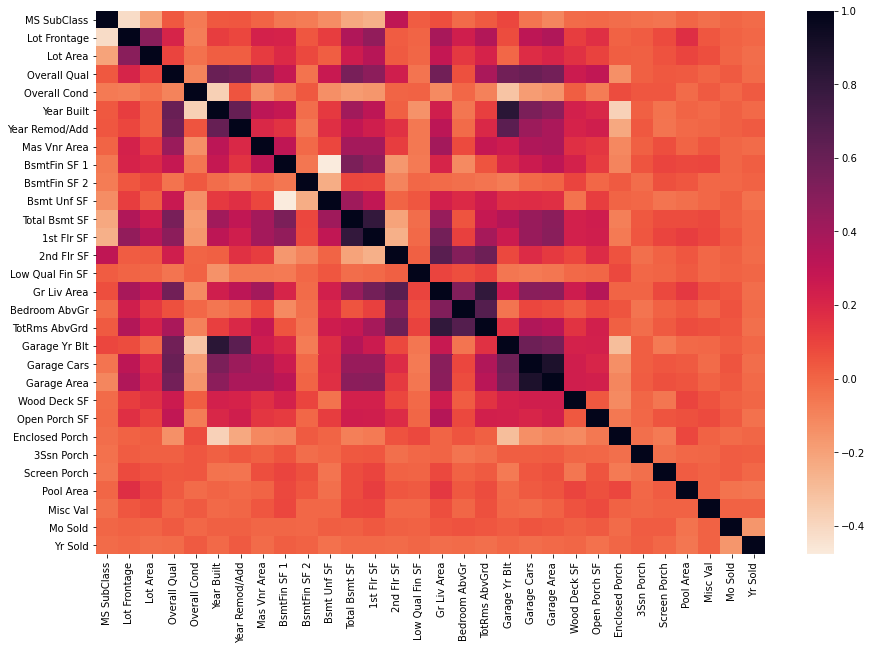

In [120]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize = (15,10))
sns.heatmap(df.drop('SalePrice',axis=1).corr(), cmap = sns.cm.rocket_r)


In [121]:
df = df.drop(['Garage Yr Blt', 'Garage Cars'], axis=1)
df

,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bedroom AbvGr,TotRms AbvGrd,Garage Area,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice
0,20,141.0,31770,6,5,1960,1960,112.0,639.0,0.0,441.0,1080.0,1656,0,0,1656,3,7,528.0,210,62,0,0,0,0,0,5,2010,215000
1,20,80.0,11622,5,6,1961,1961,0.0,468.0,144.0,270.0,882.0,896,0,0,896,2,5,730.0,140,0,0,0,120,0,0,6,2010,105000
2,20,81.0,14267,6,6,1958,1958,108.0,923.0,0.0,406.0,1329.0,1329,0,0,1329,3,6,312.0,393,36,0,0,0,0,12500,6,2010,172000
3,20,93.0,11160,7,5,1968,1968,0.0,1065.0,0.0,1045.0,2110.0,2110,0,0,2110,3,8,522.0,0,0,0,0,0,0,0,4,2010,244000
4,60,74.0,13830,5,5,1997,1998,0.0,791.0,0.0,137.0,928.0,928,701,0,1629,3,6,482.0,212,34,0,0,0,0,0,3,2010,189900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,80,37.0,7937,6,6,1984,1984,0.0,819.0,0.0,184.0,1003.0,1003,0,0,1003,3,6,588.0,120,0,0,0,0,0,0,3,2006,142500
2926,20,NaN,8885,5,5,1983,1983,0.0,301.0,324.0,239.0,864.0,902,0,0,902,2,5,484.0,164,0,0,0,0,0,0,6,2006,131000
2927,85,62.0,10441,5,5,1992,1992,0.0,337.0,0.0,575.0,912.0,970,0,0,970,3,6,0.0,80,32,0,0,0,0,700,7,2006,132000
2928,20,77.0,10010,5,5,1974,1975,0.0,1071.0,123.0,195.0,1389.0,1389,0,0,1389,2,6,418.0,240,38,0,0,0,0,0,4,2006,170000


### Scale -1 to 1
To optmize de algorithm, we will convert all the data values to numbers between -1 to 1 <br>
Para otimizar o algorítmo, nós iremos converter todo os dados numéricos para números entre -1 e 1

In [122]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

x = data #returns a numpy array
x_scaled = min_max_scaler.fit_transform(x)
x = pd.DataFrame(x_scaled)

y = df['SalePrice'].values #returns a numpy array
y_scaled = min_max_scaler.fit_transform(y.reshape(-1,1))
y = pd.DataFrame(y_scaled)




# from sklearn.model_selection import train_test_split
# X_train, X_test = train_test_split(df,test_size=0.33, random_state=42)

# from sklearn.preprocessing import OneHotEncoder
# # Create the encoder.
# encoder = OneHotEncoder(handle_unknown="ignore")
# encoder.fit(X_train)    # Assume for simplicity all features are categorical.

# # Apply the encoder.
# X_train = encoder.transform(X_train)
# X_test = encoder.transform(X_test)

### Model selection by cross validation
Validating the best model to be used <br>
Validando o melhor modelo a ser usado



In [123]:
from sklearn.linear_model import ElasticNet, Lasso, LinearRegression
from sklearn.model_selection import cross_val_score
model_list = [LinearRegression,ElasticNet, Lasso]

for m in model_list:
  model = m()
  print(model,cross_val_score(model, x, y, cv=3))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False) [0.85459284 0.80545135 0.78764691]
ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False) [-0.00126211 -0.01770987 -0.01204895]
Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) [-0.00126211 -0.01770987 -0.01204895]


### Split data/Dividindo os dados
Here i will split the data in train and test datasets <br>
Aqui eu irei dividir os dados em datasets de treino e teste

In [124]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)


### Linear regression
At this step the linear regression algorithm will be used to predict the price of a house. In the end it will be calculated the accuracy of the prediction using MSE (mean square error) and RMSE (root mean square error) <br>
Nesta etapa um algoritmo de linera regression será usado para prever o preço de uma casa. No fim será calculado a acurácia de predição usando MSE (mean square error) e RMSE (root mean square error)

In [125]:

import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

linearRegressor = LinearRegression()
linearRegressor.fit(X_train, y_train)
yPrediction = linearRegressor.predict(X_test)


from sklearn.metrics import mean_squared_error


MSE = mean_squared_error(yPrediction,y_test)
RMSE = np.sqrt(MSE) 
print('MSE:',MSE,'RMSE:',RMSE)





MSE: 0.0019113340720569322 RMSE: 0.043718806846218164


In [126]:
res = pd.DataFrame()
pred = min_max_scaler.inverse_transform(yPrediction)
res['pred'] = pred[:,0]
res['test'] = min_max_scaler.inverse_transform(y_test)
res


,pred,test
0,186802.937645,161000.0
1,121829.675604,116000.0
2,222850.826117,196500.0
3,129491.378158,123600.0
4,142000.283897,126000.0
...,...,...
962,180596.705528,170000.0
963,55418.461859,72000.0
964,190591.407746,189500.0
965,219448.122040,207000.0
